In [55]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
print(cv2.__version__)
print(tf.__version__)

4.9.0
2.15.0


In [56]:
def get_image_paths(root_folder, image_extensions=('.jpg', '.jpeg', '.png')):
    image_paths = []
    for foldername, __, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(image_extensions):
                image_paths.append(os.path.join(foldername, filename))
    return image_paths

# Specify the root folder
root_folder = 'data'

# Get image paths
image_paths = get_image_paths(root_folder)

0


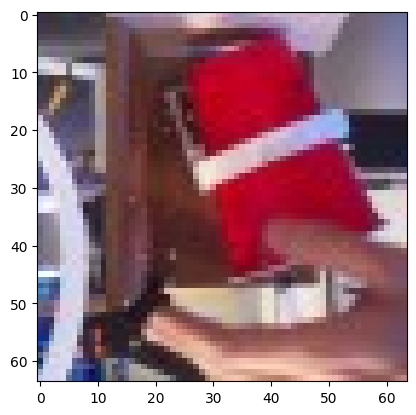

(520, 64, 64, 3)
[[[0.23529412 0.18823529 0.28235294]
  [0.23921569 0.19607843 0.2627451 ]
  [0.23921569 0.2        0.23529412]
  ...
  [0.43137255 0.43137255 0.57254902]
  [0.42352941 0.43921569 0.58823529]
  [0.41568627 0.43529412 0.59215686]]

 [[0.23529412 0.18823529 0.28235294]
  [0.23529412 0.19215686 0.25882353]
  [0.23529412 0.19607843 0.22745098]
  ...
  [0.43921569 0.43921569 0.58039216]
  [0.43137255 0.44705882 0.59607843]
  [0.42352941 0.44313725 0.6       ]]

 [[0.25098039 0.21176471 0.30588235]
  [0.25882353 0.21568627 0.28235294]
  [0.25882353 0.22352941 0.23529412]
  ...
  [0.45098039 0.45098039 0.59215686]
  [0.44705882 0.45490196 0.60784314]
  [0.43921569 0.45098039 0.61176471]]

 ...

 [[0.28627451 0.37647059 0.50196078]
  [0.76470588 0.82352941 0.94509804]
  [0.81176471 0.81568627 0.93333333]
  ...
  [0.58823529 0.40784314 0.41568627]
  [0.52156863 0.3372549  0.36078431]
  [0.48235294 0.29803922 0.32156863]]

 [[0.60784314 0.6627451  0.77647059]
  [0.80392157 0.8392

In [57]:
X = np.array(list(map(lambda path: cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), image_paths)))
X = X / 255.0
Y = np.array([1 if 'cup' in path else 0 for path in image_paths])

display = 3
print(Y[display])
plt.imshow(X[display], cmap='gray')
plt.show()
print(X.shape)
print(X[display])

In [58]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 12544)             0         
                                                                 
 dense_16 (Dense)            (None, 128)              

In [59]:
# Train the model with less verbosity
history = model.fit(X_train, Y_train, epochs=45, validation_data=(X_test, Y_test), verbose=2)

Epoch 1/45
13/13 - 2s - loss: 0.7146 - accuracy: 0.5962 - val_loss: 0.6359 - val_accuracy: 0.8173 - 2s/epoch - 118ms/step
Epoch 2/45
13/13 - 1s - loss: 0.5647 - accuracy: 0.7644 - val_loss: 0.4226 - val_accuracy: 0.8077 - 664ms/epoch - 51ms/step
Epoch 3/45
13/13 - 1s - loss: 0.3647 - accuracy: 0.8341 - val_loss: 0.2208 - val_accuracy: 0.9038 - 730ms/epoch - 56ms/step
Epoch 4/45
13/13 - 1s - loss: 0.2456 - accuracy: 0.9159 - val_loss: 0.2055 - val_accuracy: 0.9231 - 727ms/epoch - 56ms/step
Epoch 5/45
13/13 - 1s - loss: 0.1713 - accuracy: 0.9375 - val_loss: 0.0865 - val_accuracy: 0.9808 - 689ms/epoch - 53ms/step
Epoch 6/45
13/13 - 1s - loss: 0.1043 - accuracy: 0.9760 - val_loss: 0.0435 - val_accuracy: 1.0000 - 674ms/epoch - 52ms/step
Epoch 7/45
13/13 - 1s - loss: 0.0658 - accuracy: 0.9808 - val_loss: 0.0408 - val_accuracy: 0.9904 - 684ms/epoch - 53ms/step
Epoch 8/45
13/13 - 1s - loss: 0.0758 - accuracy: 0.9712 - val_loss: 0.0260 - val_accuracy: 1.0000 - 717ms/epoch - 55ms/step
Epoch 9/45

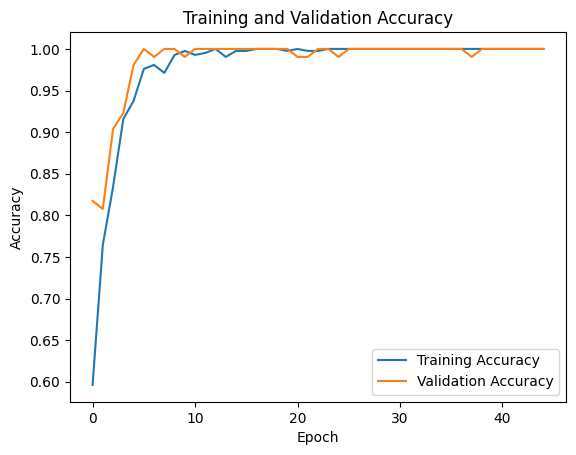

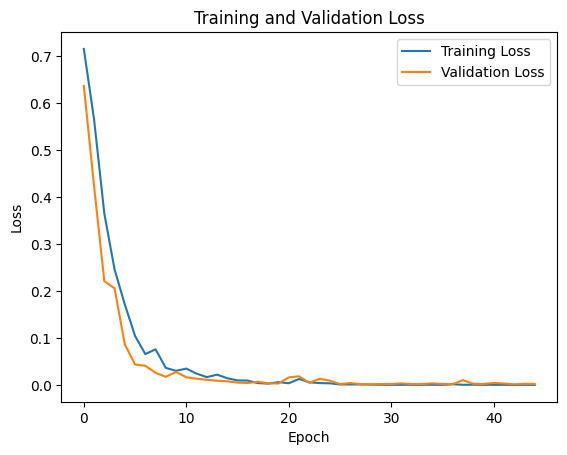

In [60]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")

4/4 [==============================] - 0s 7ms/step - loss: 0.0023 - accuracy: 1.0000
Test accuracy: 1.0


In [62]:
# Save the trained model
model.save('model.h5', save_format='h5')